## Interpolacja Vanna-Volga

In [1]:
import numpy as np
import if2 as if2
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

---
### Funkcja, która wyznacza cenę wykonania $K_\text{ATM}$
* ATM Spot - parametr "ATM-S"
* ATM Forward - parametr "ATM-F"
* ATM 0 Delta Straddle - parametr "ATM-0D"

In [2]:
def ATM_strike2(type_atm,is_pi,FXspot,sigma_atm,df_d,df_f,tau):
    FXfwd = FXspot*df_f/df_d
    if type_atm.upper() == "ATM-S":
        K_ATM = FXspot
    elif type_atm.upper() == "ATM-F":
        K_ATM = FXfwd
    elif type_atm.upper() == "ATM-0D":
        eta   = 1-2*float(is_pi)                       # is_pi = True - delta z premią 
        K_ATM = FXfwd*np.exp(eta*0.5*sigma_atm**2*tau)
    return K_ATM

In [3]:
FXspot = 4.75

Opt_type = "Call"
omega    = 2.0*float(Opt_type.upper()=="CALL")-1
vol      = 0.2
tau      = 1.0
T        = 1.0
r_d      = 0.05
r_f      = 0.02
df_f     = np.exp(-r_f*T)
df_d     = np.exp(-r_d*T)

print("*** Delta spot/fwd ***")
type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii
K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
print(f"K_ATM-0D, delta {'  z premią' if is_pi else 'bez premii'}: {K_ATM: 6.4f}")

is_pi         = False # True / False if delta jest z / bez premii
K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
print(f"K_ATM-0D, delta {'  z premią' if is_pi else 'bez premii'}: {K_ATM: 6.4f}")

print("*** Delta spot/fwd, delta z/bez premii ***")
type_atm      = "ATM-F"
is_pi         = True # True / False if delta jest z / bez premii
K_ATM = if2.ATM_Strike('ATM-F',is_pi,FXspot,vol,df_d,df_f,tau)
print(f"K_ATM-F                     {K_ATM: 6.4f}")


*** Delta spot/fwd ***
K_ATM-0D, delta   z premią:  4.7977
K_ATM-0D, delta bez premii:  4.9935
*** Delta spot/fwd, delta z/bez premii ***
K_ATM-F                      4.8947


---
# Wyznaczanie zmienności implikowanej z ceny opcji

In [4]:
FXspot = 4.75
T      = 182/365
r_d    = 0.05
r_f    = 0.02
df_f   = np.exp(-r_f*T)
df_d   = np.exp(-r_d*T)
FXfwd  = FXspot*df_f/df_d

omega = 1
K     = 4.55
Value_mkt = 0.40

impvol=if2.ImpVol(Value_mkt,omega,FXspot,df_d,df_f,K,T)
print("Zmienność implikowana: %5.4f" %impvol)

Zmienność implikowana: 0.1906


In [5]:
def vv_int5(K,smile_data):
    (K1,sig1,K2,sig2,K3,sig3) = smile_data
    x1 = (np.log(K/K2)*np.log(K/K3))/(np.log(K1/K2)*np.log(K1/K3))
    x2 = (np.log(K/K1)*np.log(K/K3))/(np.log(K2/K1)*np.log(K2/K3))
    x3 = (np.log(K/K1)*np.log(K/K2))/(np.log(K3/K1)*np.log(K3/K2))
    sigmaK = x1*sig1 + x2*sig2 + x3*sig3
    return sigmaK

FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

FXfwd = FXspot*df_f/df_d

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,sig_atm,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

smile_data = K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c

K=1.3
vol = if2.vv_int1s(K,smile_data)
vol


0.09178125318040545

---
# Interpolacja Vanna-Volga (I rzędu i II rzędu)

In [6]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

FXfwd=FXspot*df_f/df_d

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,sig_atm,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

smile_data = K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c

K=1.3 
volK  = if2.vv_int1s(K,smile_data)
volK2 = if2.vv_int2s(K,smile_data,FXfwd,tau)
print("K_25P: %6.4f" %K_25P,"K_ATM: %6.4f" %K_ATM,"K_25C: %6.4f" %K_25C)
print("Zmienność 25D put  %5.4f" %sig_25p)
print("Zmienność 25D call %5.4f" %sig_25c)
print("Zmienność dla ceny wykonania %5.4f" %K,"wynosi %5.4f" %volK, "(interpolacja VV I rzędu)")
print("Zmienność dla ceny wykonania %5.4f" %K,"wynosi %5.4f" %volK2, "(interpolacja VV II rzędu)")

K_25P: 1.1721 K_ATM: 1.2090 K_25C: 1.2476
Zmienność 25D put  0.0943
Zmienność 25D call 0.0893
Zmienność dla ceny wykonania 1.3000 wynosi 0.0918 (interpolacja VV I rzędu)
Zmienność dla ceny wykonania 1.3000 wynosi 0.0918 (interpolacja VV II rzędu)


---
# Wykresy interpolowanego uśmiechu zmienności

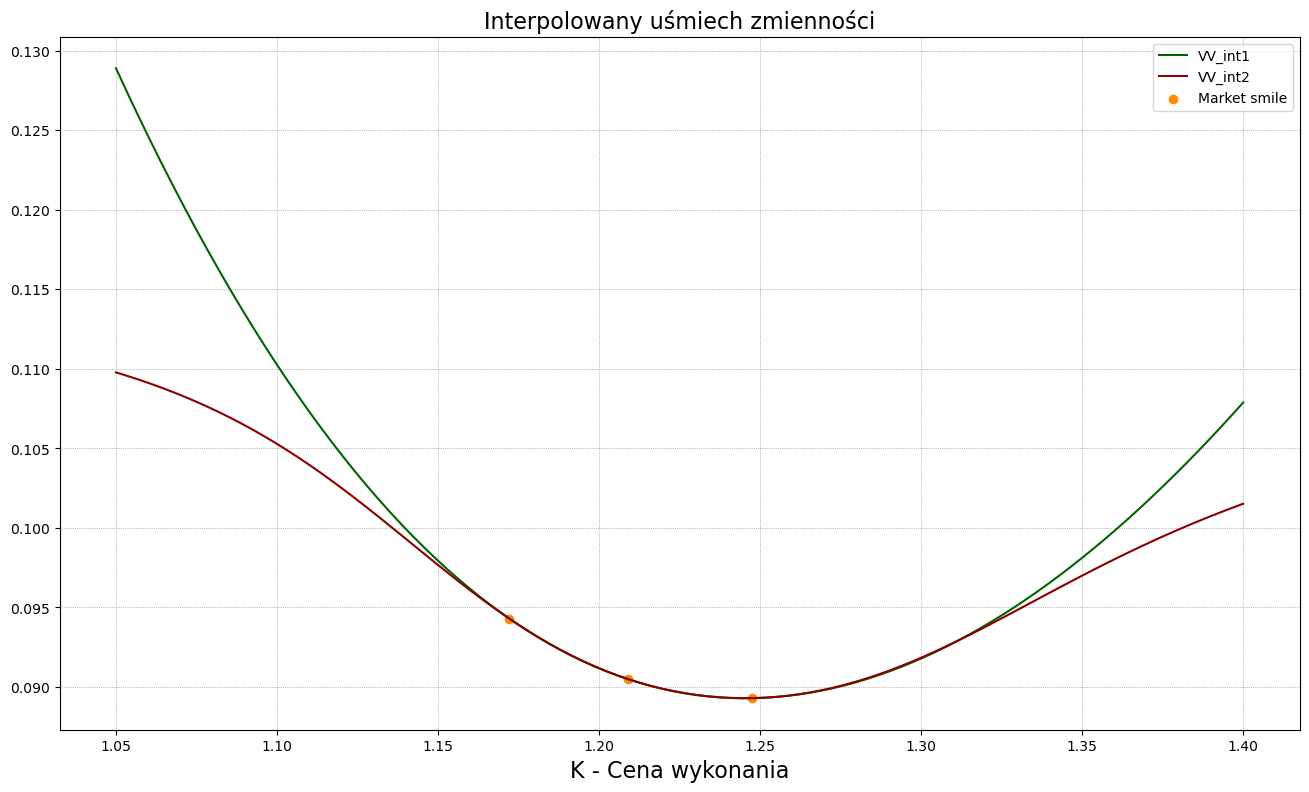

In [7]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

FXfwd=FXspot*df_f/df_d

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

Strike=np.linspace(1.05,1.4,100)

sig=np.array([sig_25p,sig_atm,sig_25c])
K_sig=np.array([K_25P,K_ATM,K_25C])

fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Interpolowany uśmiech zmienności",fontsize=16)
axl.set_xlabel("K - Cena wykonania",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
axl.plot(Strike,[if2.vv_int1s(K,smile_data)         for K in Strike],color="darkgreen",linewidth=1.5,label="VV_int1")
axl.plot(Strike,[if2.vv_int2s(K,smile_data,FXfwd,T) for K in Strike],color="darkred",linewidth=1.5,label="VV_int2")
axl.scatter(K_sig,sig,color="darkorange",label="Market smile")
#axl.scatter(K_ATM,0.0,color="orange",label="$K_{ATM}$")
#zero=np.array([0,0,0])
#K_range=np.array([K_25P,K_ATM,K_25C])
#axl.scatter(K_range,zero,color="black")
plt.legend()

---
# Efekt zmiany kursu FX spot na uśmiech zmienności jako funkcji ceny wykonania

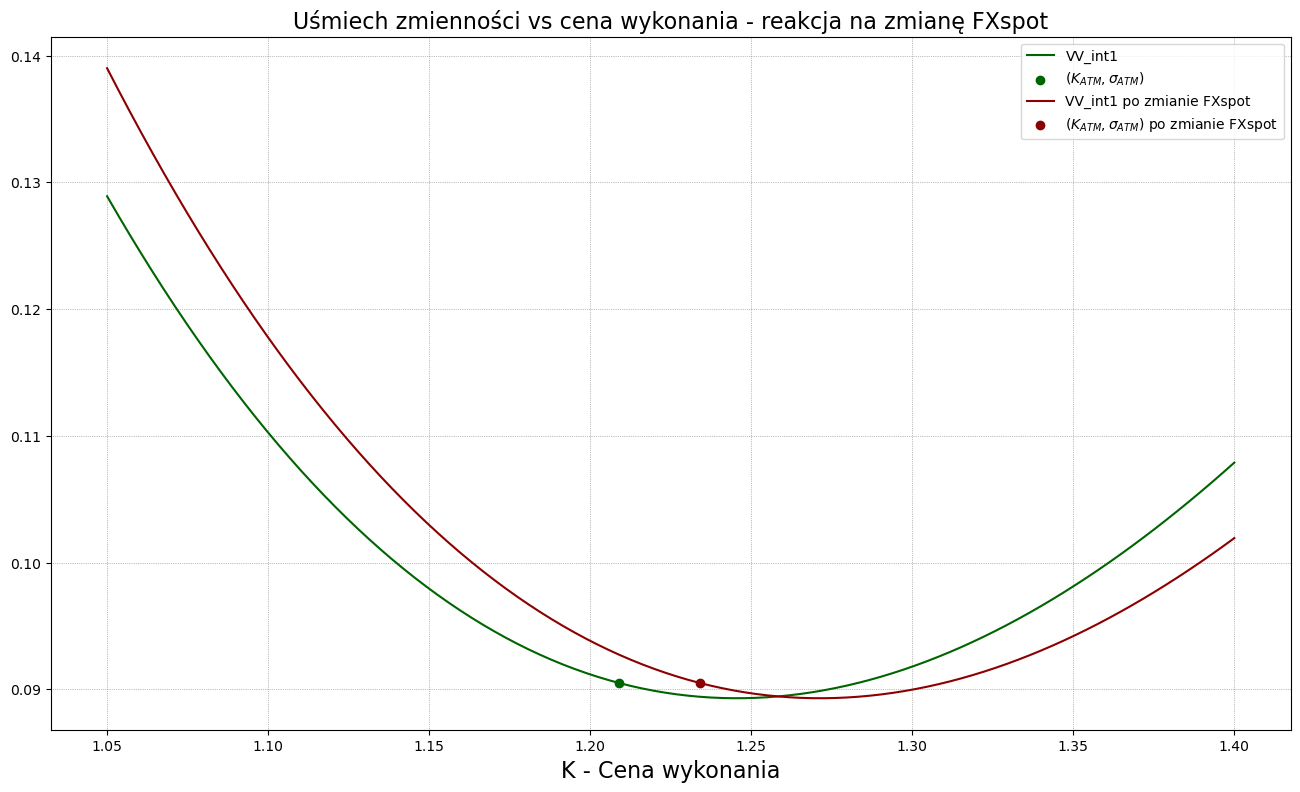

In [8]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

Strike=np.linspace(1.05,1.4,100)

fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Uśmiech zmienności vs cena wykonania - reakcja na zmianę FXspot",fontsize=16)
axl.set_xlabel("K - Cena wykonania",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
axl.plot(Strike,[if2.vv_int1s(K,smile_data) for K in Strike],color="darkgreen",linewidth=1.5,label="VV_int1")
axl.scatter(K_ATM,sig_atm,color="darkgreen",label="$(K_{ATM},\sigma_{ATM})$")

FXspot = 1.205+0.025 # przesuwamy FXspot
K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
plt.plot(Strike,[if2.vv_int1s(K,smile_data) for K in Strike],color="darkred",linewidth=1.5,label="VV_int1 po zmianie FXspot")
axl.scatter(K_ATM,sig_atm,color="darkred",label="$(K_{ATM},\sigma_{ATM})$ po zmianie FXspot")
plt.legend()

---
# Efekt zmiany kursu FX spot na uśmiech zmienności jako funkcji delty

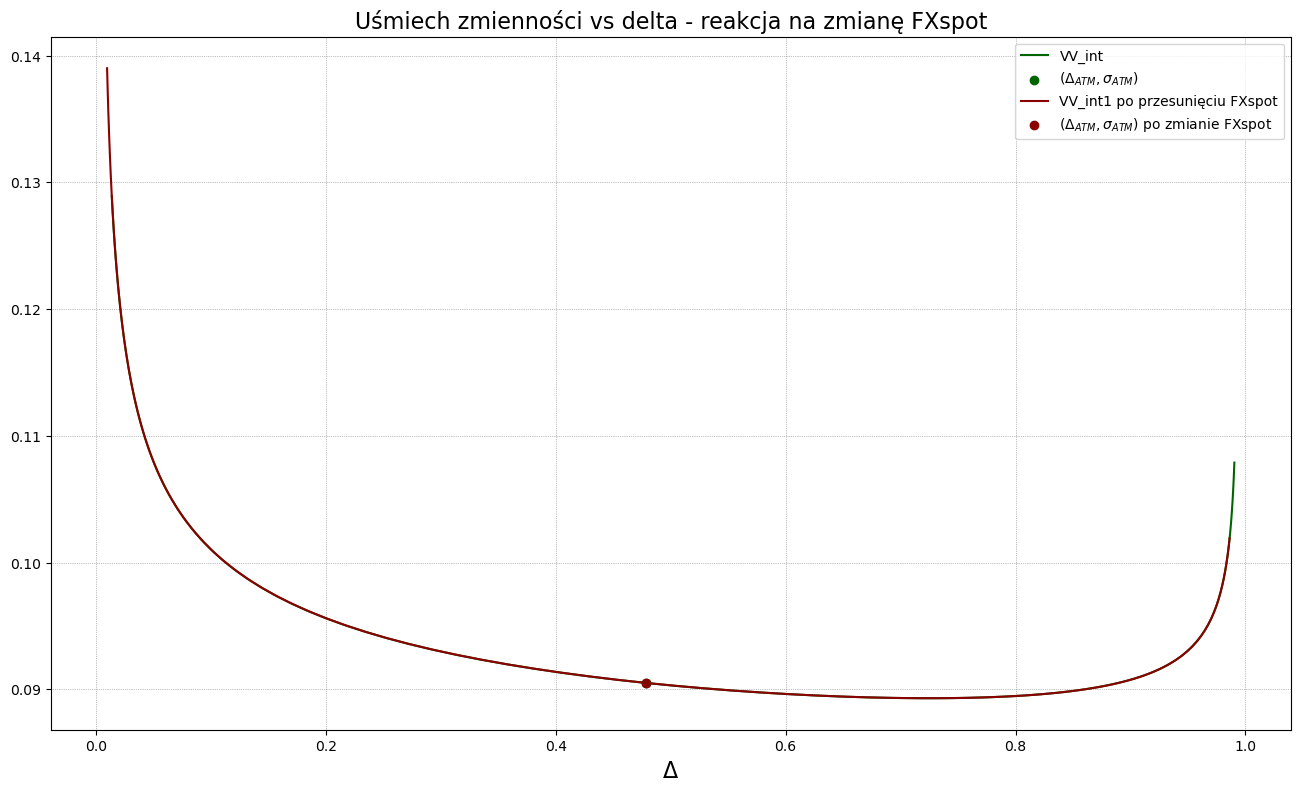

In [9]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

Strike=np.linspace(1.05,1.4,100)

fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Uśmiech zmienności vs delta - reakcja na zmianę FXspot",fontsize=16)
axl.set_xlabel("$\Delta$",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
Sigma = if2.vv_int1s(Strike,smile_data)
Delta =-if2.DeltaBS(-1,FXspot, Sigma, df_d, df_f, Strike, tau, 1)
plt.plot(Delta,[if2.vv_int1s(K,smile_data) for K in Strike],color="darkgreen",linewidth=1.5,label="VV_int")
Delta_ATM = -if2.DeltaBS(-1,FXspot, sig_atm, df_d, df_f, K_ATM, tau, 1)
axl.scatter(Delta_ATM,sig_atm,color="darkgreen",label="$(\Delta_{ATM},\sigma_{ATM})$")

FXspot = 1.205+0.025
K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
Sigma = if2.vv_int1s(Strike,smile_data)
Delta =-if2.DeltaBS(-1,FXspot, Sigma, df_d, df_f, Strike, tau, 1)
plt.plot(Delta,[if2.vv_int1s(K,smile_data) for K in Strike],color="darkred",linewidth=1.5,label="VV_int1 po przesunięciu FXspot")
Delta_ATM = -if2.DeltaBS(-1,FXspot, sig_atm, df_d, df_f, K_ATM, tau, 1)
axl.scatter(Delta_ATM,sig_atm,color="darkred",label="$(\Delta_{ATM},\sigma_{ATM})$ po zmianie FXspot")
plt.legend()

---
# Analiza działania interpolacji vv_int1 - wagi $x_1$, $x_2$, oraz $x_3$

In [10]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

def vv_wagi(K,K1,K2,K3):
    x1=(np.log(K/K2)*np.log(K/K3))/(np.log(K1/K2)*np.log(K1/K3))
    x2=(np.log(K/K1)*np.log(K/K3))/(np.log(K2/K1)*np.log(K2/K3))
    x3=(np.log(K/K1)*np.log(K/K2))/(np.log(K3/K1)*np.log(K3/K2))
    suma=x1+x2+x3
    return x1, x2, x3, suma

K = 1.15
for k in 0,1,2:
    print(f"waga_{k+1} = {vv_wagi(K,K_25P,K_ATM,K_25C)[k]:6.4f}")
print(f"suma   = {vv_wagi(K,K_25P,K_ATM,K_25C)[3]:6.4f}")

waga_1 = 2.1100
waga_2 = -1.5943
waga_3 = 0.4842
suma   = 1.0000


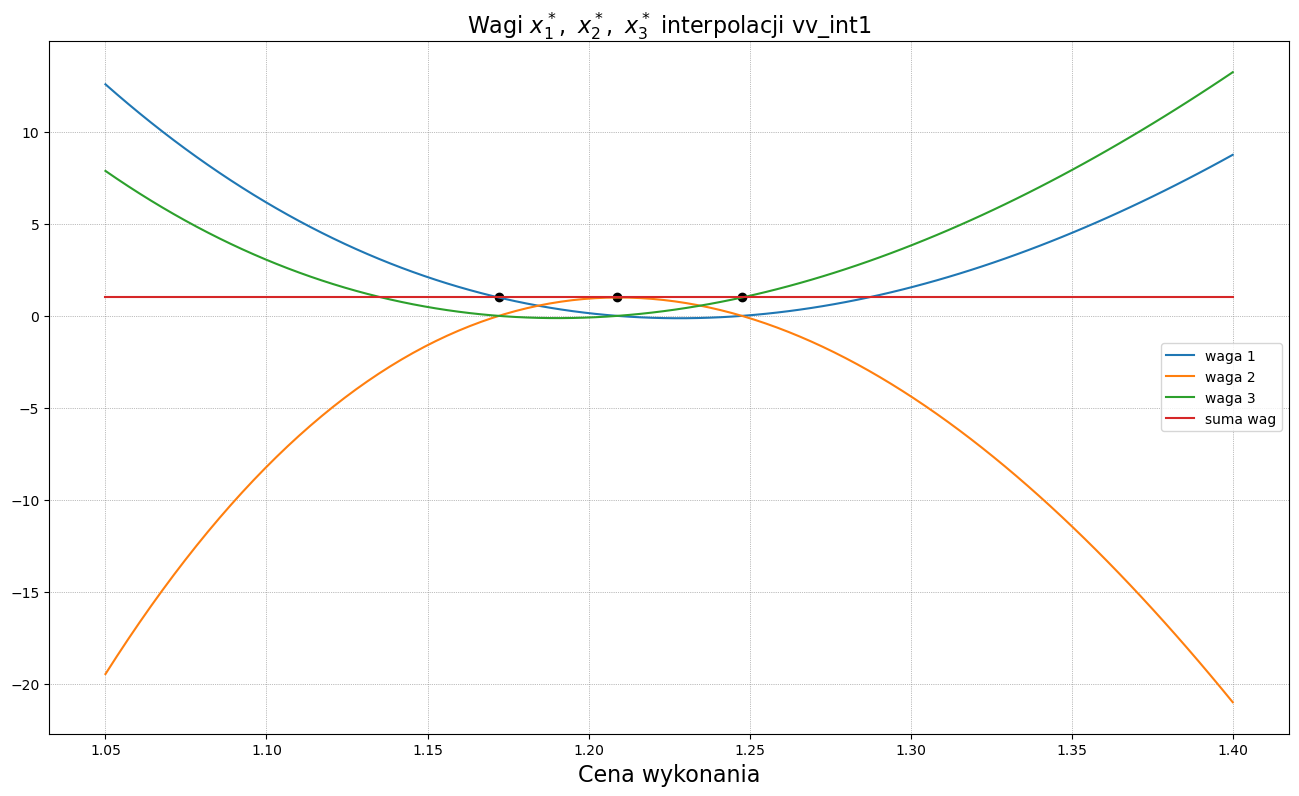

In [11]:
fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Wagi $x^*_1,\ x^*_2,\ x^*_3$ interpolacji vv_int1",fontsize=16)
axl.set_xlabel("Cena wykonania",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)

Strike=np.linspace(1.05,1.4,100)

for i in (0,1,2):
    plt.plot(Strike,[vv_wagi(K,K_25P,K_ATM,K_25C)[i] for K in Strike],label=f"waga {i+1}")
plt.plot(Strike,[vv_wagi(K,K_25P,K_ATM,K_25C)[3] for K in Strike],label="suma wag")

w_25P = vv_wagi(K_25P,K_25P,K_ATM,K_25C)[0]
w_ATM = vv_wagi(K_ATM,K_25P,K_ATM,K_25C)[1]
w_25C = vv_wagi(K_25C,K_25P,K_ATM,K_25C)[2]
wagi_K  = np.array([w_25P,w_ATM,w_25C])
K_range = np.array([K_25P,K_ATM,K_25C])
axl.scatter(K_range,wagi_K,color="black")
plt.legend()      

---
# Analiza działania interpolacji vv_int2

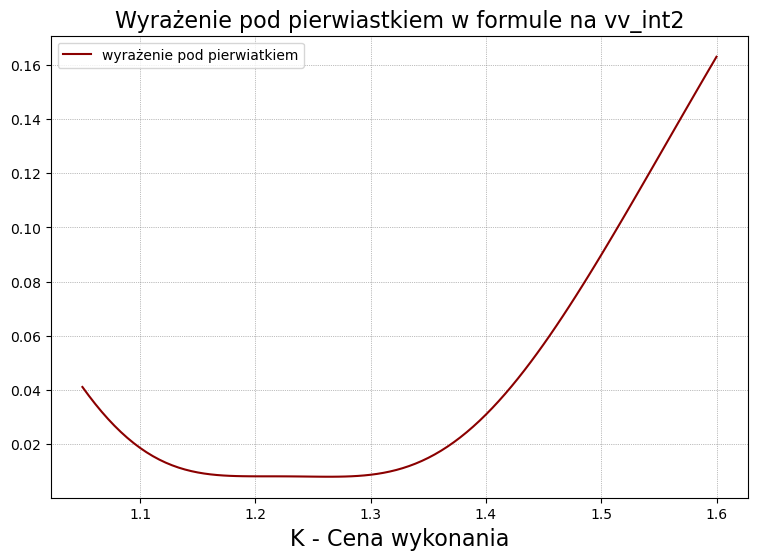

In [12]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

FXfwd = FXspot*df_f/df_d

def temp(K,smile_data,FXfwd,T):
    K1,sig1,K2,sig2,K3,sig3 = smile_data
    x1 = (np.log(K/K2)*np.log(K/K3))/(np.log(K1/K2)*np.log(K1/K3))
    x3 = (np.log(K/K1)*np.log(K/K2))/(np.log(K3/K1)*np.log(K3/K2))
    sig1K = if2.vv_int1s(K,smile_data)
    d1K   = (np.log(FXfwd/K)+0.5*sig2**2*T)/(sig1K*np.sqrt(T))
    d2K   = d1K-sig2*np.sqrt(T)
    d12K  = d1K*d2K
    d1K1  = (np.log(FXfwd/K1)+0.5*sig1**2*T)/(sig1*np.sqrt(T))
    d2K1  = d1K1-sig1*np.sqrt(T)
    d12K1 = d1K1*d2K1
    d1K3  = (np.log(FXfwd/K3)+0.5*sig3**2*T)/(sig3*np.sqrt(T))
    d2K3  = d1K3-sig3*np.sqrt(T)
    d12K3 = d1K3*d2K3
    nu1   = sig1K-sig2
    nu2   = x1*d12K1*(sig1-sig2)**2+x3*d12K3*(sig3-sig2)**2
    tmp   = sig2**2+d12K*(2*sig2*nu1+nu2)
    return tmp

Strike=np.linspace(1.05,1.6,100)

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wyrażenie pod pierwiastkiem w formule na vv_int2",fontsize=16)
axl.set_xlabel("K - Cena wykonania",fontsize=16)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
plt.plot(Strike,[temp(K,smile_data,FXfwd,tau) for K in Strike],color="darkred",linewidth=1.5,label="wyrażenie pod pierwiatkiem")
plt.legend()

---
# Zmienność implikowana z cen Vanna-Volga vs interpolacje Vanna-Volga

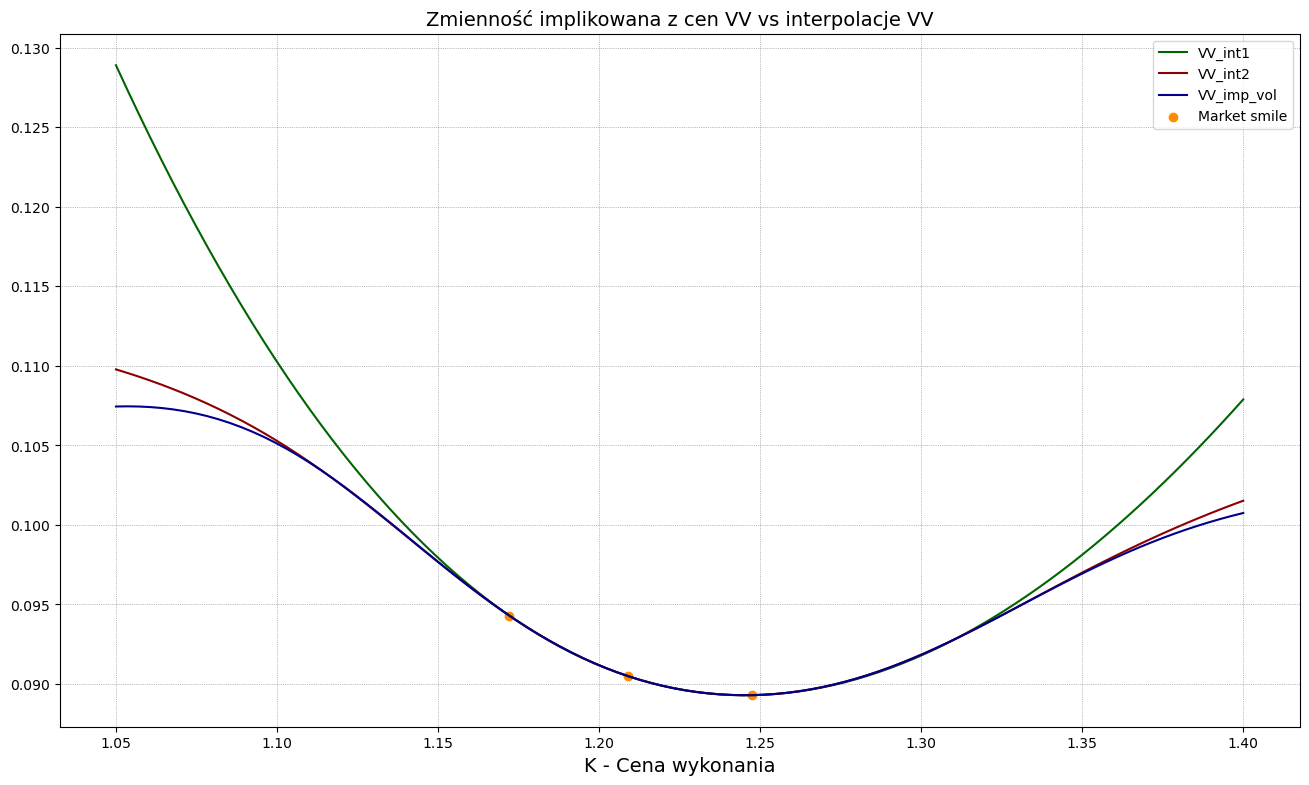

In [13]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

FXfwd = FXspot*df_f/df_d

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

Strike     = np.linspace(1.05,1.4,100)
VV_Price   = if2.VV_value(omega,FXspot,df_d,df_f,Strike,T,1,smile_data)
Imp_Vol_VV = np.zeros(len(Strike))
for i in range(len(Strike)):
    Imp_Vol_VV[i] = if2.ImpVol(VV_Price[i],omega,FXspot,df_d,df_f,Strike[i],tau)



fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Zmienność implikowana z cen VV vs interpolacje VV",fontsize=14)
axl.set_xlabel("K - Cena wykonania",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
axl.plot(Strike,[if2.vv_int1s(K,smile_data) for K in Strike],color="darkgreen",linewidth=1.5,label="VV_int1")
axl.plot(Strike,[if2.vv_int2s(K,smile_data,FXfwd,T) for K in Strike],color="darkred",linewidth=1.5,label="VV_int2")
axl.plot(Strike,Imp_Vol_VV,color="darkblue",linewidth=1.5,label="VV_imp_vol")

sig   = np.array([sig_25p,sig_atm,sig_25c])
K_sig = np.array([K_25P,K_ATM,K_25C])
axl.scatter(K_sig,sig,color="darkorange",label="Market smile")
zero    = np.array([0,0,0])
K_range = np.array([K_25P,K_ATM,K_25C])
#axl.scatter(K_range,zero,color="black")
axl.legend()
#plt.savefig("VV_vol_vs_Strike.pdf")

[0.24294675 0.47881668 0.73772503]


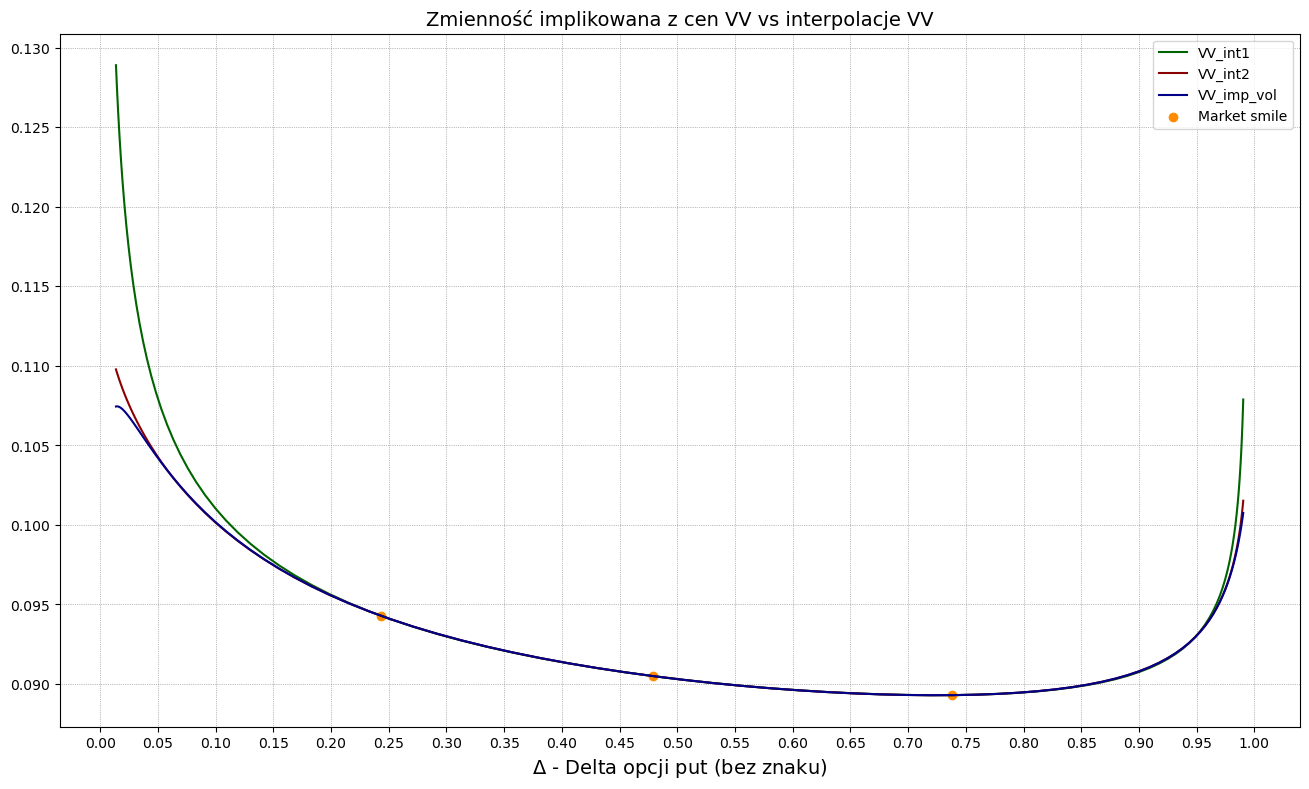

In [14]:
fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Zmienność implikowana z cen VV vs interpolacje VV",fontsize=14)
axl.set_xlabel("$\Delta$ - Delta opcji put (bez znaku)",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
Strike = np.linspace(1.05,1.4,100)
Sigma  = if2.vv_int1s(Strike,smile_data)
Delta  =-if2.DeltaBS(-1,FXspot, Sigma, df_d, df_f, Strike, tau, 1)
axl.set_xticks(np.linspace(0,1,21))
axl.plot(Delta,[if2.vv_int1s(K,smile_data)         for K in Strike],color="darkgreen",linewidth=1.5,label="VV_int1")
axl.plot(Delta,[if2.vv_int2s(K,smile_data,FXfwd,T) for K in Strike],color="darkred",  linewidth=1.5,label="VV_int2")
axl.plot(Delta,Imp_Vol_VV,color="darkblue",linewidth=1.5,label="VV_imp_vol")
sig       = np.array([sig_25p,sig_atm,sig_25c])
K_sig     = np.array([K_25P,K_ATM,K_25C])
Delta_sig =-if2.DeltaBS(-1,FXspot, sig, df_d, df_f, K_sig, tau, 1)
print(Delta_sig)
axl.scatter(Delta_sig,sig,color="darkorange",label="Market smile")
axl.legend()
#plt.savefig("VV_vol_vs_Delta.pdf")

---
# Funkcja celu na potrzeby kalibracji interpolacji

K_25P_STRG:  1.17 K_25C_STRG:  1.25
sig_stgl_25p 0.0942 sig_stgl_25c 0.0893
STGL_mkt_val:  0.01678
-3.413544771152521e-05


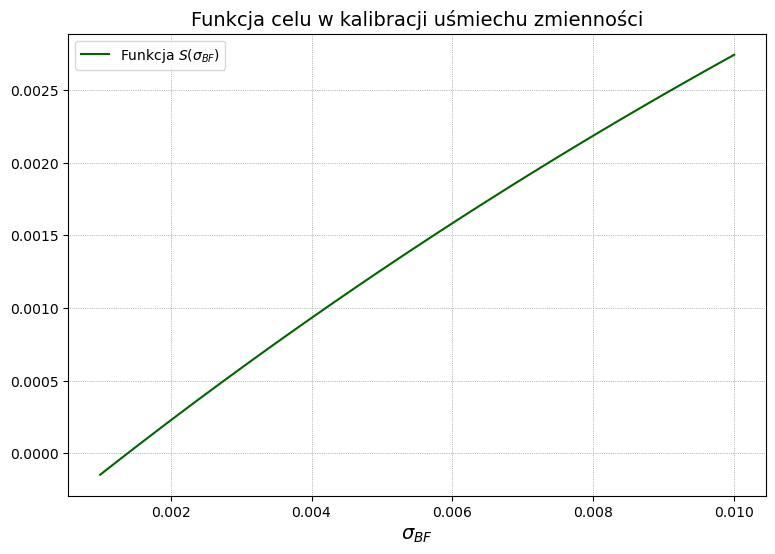

In [15]:
#USD/JPY
#FXspot=90.68
#T=31/365
#df_f=np.exp(-0.003525*T)
#df_d=np.exp(-0.004875*T)
#sig_atm=0.21
#sig_rr=-0.053
#sig_bf=0.00184
#type_atm = "ATM 0-D"
#is_spot = True
#is_pi   = True

FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013

sig_25c  = sig_atm + 0.5*sig_rr + sig_bf
sig_25p  = sig_atm - 0.5*sig_rr + sig_bf
sig_stgl = sig_atm + sig_bf

type_atm = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM      = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C      = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,tau)
K_25P      = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,tau)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

K_25P_STRG = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_stgl,df_d,df_f,tau)
K_25C_STRG = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_stgl,df_d,df_f,tau)
sig_stgl_25p=if2.vv_int1s(K_25P_STRG,smile_data)
sig_stgl_25c=if2.vv_int1s(K_25C_STRG,smile_data)
print("K_25P_STRG: %5.2f" %K_25P_STRG,"K_25C_STRG: %5.2f" %K_25C_STRG)
print("sig_stgl_25p %5.4f" %sig_stgl_25p,"sig_stgl_25c %5.4f" %sig_stgl_25c)
V_stgl_25p=if2.ValueBS(-1, FXspot, sig_stgl, df_d, df_f, K_25P_STRG, tau, 1)
V_stgl_25c=if2.ValueBS( 1, FXspot, sig_stgl, df_d, df_f, K_25C_STRG, tau, 1)
STGL_mkt_val=V_stgl_25c+V_stgl_25p
print("STGL_mkt_val: %8.5f" %STGL_mkt_val)

S=if2.S_value(K_25P_STRG,K_25C_STRG,STGL_mkt_val,type_atm,is_spot_delta,is_pi,FXspot,df_d,df_f,tau,sig_atm,sig_rr,sig_bf)
print(S)
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Funkcja celu w kalibracji uśmiechu zmienności",fontsize=14)
axl.set_xlabel("$\sigma_{BF}$",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
Sigma=np.linspace(0.001,0.01,100)
plt.plot(Sigma,[if2.S_value(K_25P_STRG,K_25C_STRG,STGL_mkt_val,type_atm,is_spot_delta,is_pi,FXspot,df_d,df_f,T,sig_atm,sig_rr,sig) for sig in Sigma],color="darkgreen",linewidth=1.5,label="Funkcja $S(\sigma_{BF})$")
plt.legend()

In [16]:
sig=sig_bf
Sprime=if2.dS_value(K_25P_STRG,K_25C_STRG,STGL_mkt_val,type_atm,is_spot_delta,is_pi,FXspot,df_d,df_f,T,sig_atm,sig_rr,sig)
print(Sprime)

0.37690164667869563


---
# Użycie funkcji kalibrującej uśmiech zmienności. Funkcja ta wyznacza nową wartość sig_bf.

In [17]:
#USD/JPY
#FXspot=90.68
#T=31/365
#df_f=np.exp(-0.003525*T)
#df_d=np.exp(-0.004875*T)
#sig_atm=0.21
#sig_rr=-0.053
#sig_bf=0.00184

FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
#sig_atm = 0.0905
#sig_rr  =-0.0050
#sig_bf  = 0.0013

sig_atm = 0.0905
sig_rr  =-0.035
#sig_rr =-0.005
sig_bf  = 0.0053

sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf
sig_stgl = sig_atm + sig_bf

type_atm = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)
print("K_25P:        %5.2f" %K_25P,"    ","K_25C:        %5.2f" %K_25C)
print("sig_25p:      %5.4f" %sig_25p,"   ","sig_25c:      %5.4f" %sig_25c)

K_25P_STRG = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_stgl,df_d,df_f,T)
K_25C_STRG = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_stgl,df_d,df_f,T)
print("K_25P_STRG:   %5.2f" %K_25P_STRG,"    ","K_25C_STRG:   %5.2f" %K_25C_STRG)

smile_data   = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
sig_stgl_25p = if2.vv_int1s(K_25P_STRG,smile_data)
sig_stgl_25c = if2.vv_int1s(K_25C_STRG,smile_data)
print("sig_stgl_25p: %5.4f" %sig_stgl_25p,"   ","sig_stgl_25c: %5.4f" %sig_stgl_25c)

V_stgl_25p_s = if2.ValueBS(-1, FXspot, sig_stgl_25p, df_d, df_f, K_25P_STRG, T, 1)
V_stgl_25c_s = if2.ValueBS( 1, FXspot, sig_stgl_25c, df_d, df_f, K_25C_STRG, T, 1)
STGL_val_s = V_stgl_25c_s + V_stgl_25p_s
print("Przed kalibracją STGL_val_s (zmienności interpolowane): %7.5f" %STGL_val_s)

V_stgl_25p = if2.ValueBS(-1, FXspot, sig_stgl, df_d, df_f, K_25P_STRG, T, 1)
V_stgl_25c = if2.ValueBS( 1, FXspot, sig_stgl, df_d, df_f, K_25C_STRG, T, 1)
STGL_mkt_val = V_stgl_25c + V_stgl_25p
print("Przed kalibracją STGL_mkt_val: %7.5f" %STGL_mkt_val)

print("-----------------")
sig_bf_cal = if2.SmileCaliber(K_25P_STRG,K_25C_STRG,STGL_mkt_val,type_atm,is_spot_delta,is_pi,FXspot,df_d,df_f,T,sig_atm,sig_rr,sig_bf)
print("sig_bf_cal: %6.4f" %sig_bf_cal)
print("-----------------")

sig_25c = sig_atm + 0.5*sig_rr + sig_bf_cal
sig_25p = sig_atm - 0.5*sig_rr + sig_bf_cal

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)
print("K_25P:        %5.2f" %K_25P,"    ","K_25C:         %5.2f" %K_25C)
print("sig_25p:      %5.4f" %sig_25p,"    ","sig_25c:      %5.4f" %sig_25c)

smile_data   = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
sig_stgl_25p = if2.vv_int1s(K_25P_STRG,smile_data)
sig_stgl_25c = if2.vv_int1s(K_25C_STRG,smile_data)

print("sig_stgl_25p: %5.4f" %sig_stgl_25p,"    ","sig_stgl_25c: %5.4f" %sig_stgl_25c)
V_stgl_25p = if2.ValueBS(-1, FXspot, sig_stgl_25p, df_d, df_f, K_25P_STRG, T, 1)
V_stgl_25c = if2.ValueBS( 1, FXspot, sig_stgl_25c, df_d, df_f, K_25C_STRG, T, 1)
STGL_mkt_val_cal = V_stgl_25c + V_stgl_25p
print("Po kalibracji STGL_mkt_val: %7.5f" %STGL_mkt_val_cal)

K_25P:         1.16      K_25C:         1.24
sig_25p:      0.1133     sig_25c:      0.0783
K_25P_STRG:    1.17      K_25C_STRG:    1.25
sig_stgl_25p: 0.1092     sig_stgl_25c: 0.0762
Przed kalibracją STGL_val_s (zmienności interpolowane): 0.01650
Przed kalibracją STGL_mkt_val: 0.01751
-----------------
sig_bf_cal: 0.0082
-----------------
K_25P:         1.16      K_25C:          1.24
sig_25p:      0.1162      sig_25c:      0.0812
sig_stgl_25p: 0.1105      sig_stgl_25c: 0.0805
Po kalibracji STGL_mkt_val: 0.01751


---
# Efekt kalibracji na interpolację Vanna-Volga

sig_bf_cal: 0.0082


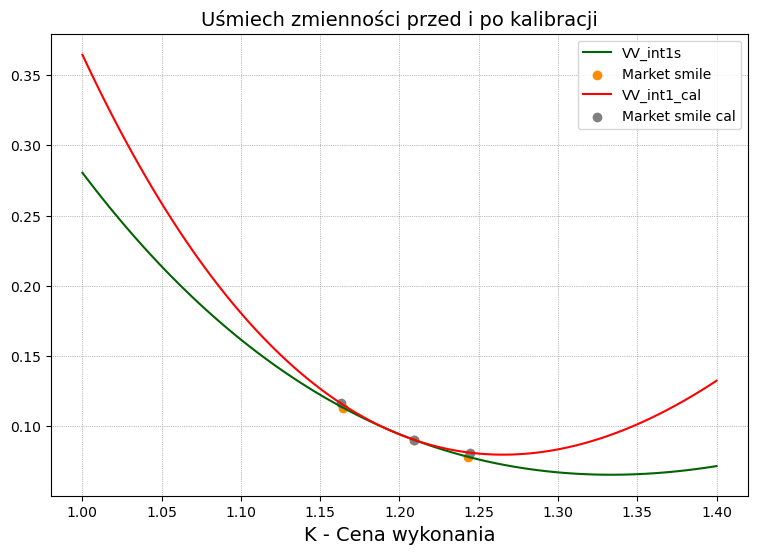

In [18]:
FXspot = 1.205
T      = 94/360
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T

sig_atm = 0.0905
sig_rr  =-0.035
#sig_rr =-0.005
sig_bf  = 0.0053

FXfwd = FXspot*df_f/df_d

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
N=1
omega=1
Strike     = np.linspace(1.0,1.4,100)
VV_Price   = if2.VV_value(omega,FXspot,df_d,df_f,Strike,T,1,smile_data)
Imp_Vol_VV = np.zeros(len(Strike))
for i in range(len(Strike)):
    Imp_Vol_VV[i]=if2.ImpVol(VV_Price[i],omega,FXspot,df_d,df_f,Strike[i],T)
    
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Uśmiech zmienności przed i po kalibracji",fontsize=14)
axl.set_xlabel("K - Cena wykonania",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(Strike,[if2.vv_int1s(K,smile_data) for K in Strike],color="darkgreen",linewidth=1.5,label="VV_int1s")

sig   = np.array([sig_25p,sig_atm,sig_25c])
K_sig = np.array([K_25P,K_ATM,K_25C])
plt.scatter(K_sig,sig,color="darkorange",label="Market smile")

sig_stgl = sig_atm + sig_bf
K_25P_STRG = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_stgl,df_d,df_f,T)
K_25C_STRG = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_stgl,df_d,df_f,T)
V_stgl_25p = if2.ValueBS(-1, FXspot, sig_stgl, df_d, df_f, K_25P_STRG, T, 1)
V_stgl_25c = if2.ValueBS( 1, FXspot, sig_stgl, df_d, df_f, K_25C_STRG, T, 1)
STGL_mkt_val=V_stgl_25c+V_stgl_25p

sig_bf_cal=if2.SmileCaliber(K_25P_STRG,K_25C_STRG,STGL_mkt_val,type_atm,is_spot_delta,is_pi,FXspot,df_d,df_f,T,sig_atm,sig_rr,sig_bf)
print('sig_bf_cal: %5.4f' % sig_bf_cal)

sig_25c = sig_atm + 0.5*sig_rr + sig_bf_cal
sig_25p = sig_atm - 0.5*sig_rr + sig_bf_cal

K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

plt.plot(Strike,[if2.vv_int1s(K,smile_data) for K in Strike],color="red",linewidth=1.5,label="VV_int1_cal")

sig   = np.array([sig_25p,sig_atm,sig_25c])
K_sig = np.array([K_25P,K_ATM,K_25C])
plt.scatter(K_sig,sig,color="gray",label="Market smile cal")
plt.legend()
#plt.savefig("VV_vol_vs_Strike.pdf")